In [23]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
contamination = lambda T,u, domega, omega : -(2*u*np.arctan((2*T*domega)/(T**2*domega**2-T**2*omega*2-1)))/np.pi

In [3]:
rad = 2*np.pi
day2sec = 24*3600
omega_0 = 1.96
domega_0 = 0.4

In [37]:
ds = xr.Dataset({'U_hat':(['Tlow','Utilde','T'],np.array([[[2,2,2],[0.02,0.03,0.04]],[[2,2,2],[0.02,0.02,0.02]]])),
                 'Tlow':[2,20],'Utilde':[2,0.02],'T':[10,20,40]})
ds

<xarray.Dataset>
Dimensions:  (Tlow: 2, Utilde: 2, T: 3)
Coordinates:
  * Tlow     (Tlow) int64 2 20
  * Utilde   (Utilde) float64 2.0 0.02
  * T        (T) int64 10 20 40
Data variables:
    U_hat    (Tlow, Utilde, T) float64 2.0 2.0 2.0 0.02 ... 2.0 0.02 0.02 0.02

In [44]:
_ = ds.U_hat/contamination(ds.Tlow,1,domega_0,omega_0)

In [45]:
_

<xarray.DataArray (Tlow: 2, Utilde: 2, T: 3)>
array([[[ 31.59864923,  31.59864923,  31.59864923],
        [  0.31598649,   0.47397974,   0.63197298]],

       [[295.51719164, 295.51719164, 295.51719164],
        [  2.95517192,   2.95517192,   2.95517192]]])
Coordinates:
  * Tlow     (Tlow) int64 2 20
  * Utilde   (Utilde) float64 2.0 0.02
  * T        (T) int64 10 20 40

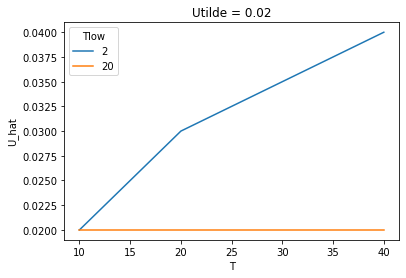

In [42]:
ds.U_hat.sel(Utilde=0.02).plot(hue='Tlow',x='T')

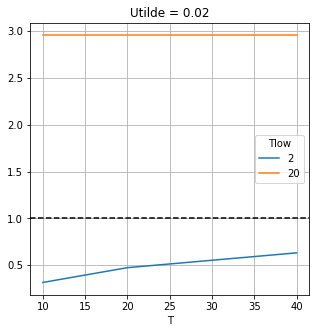

In [46]:
fig,ax = plt.subplots(figsize=(5,5))
_.sel(Utilde=0.02).plot(hue='Tlow',ax=ax)
ax.axhline(1,c='k',linestyle='--')
ax.grid()

In [9]:
xr.concat([contamination(Tl,2,domega_0,omega_0) for Tl in [2, 20]],dim='Tlow')

TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'numpy.float64'>

In [ ]:
import os
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

import mitequinox.utils as ut
import mitequinox.plot as pl

import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

In [ ]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster() #processes=7, cores=7
#w = cluster.scale(jobs=3
#                 )
#
client = Client(cluster)

In [ ]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [ ]:
def remove_duplicates(df):
    """Find duplicates in dataframe and remove them.
    Create a column 'dt_flag', False if the dt is not different from 1/24
    
    ----------------
    Parameters
    df : dataframe from which duplicates must be removed, dataframe
    
    ----------------
    Returns
    df : input dataframe without duplicates and with new column 'dt_flag', dataframe
    """
#    df = df.reset_index().drop_duplicates('time').sort_values('time')#.set_index('time')
    df = df.drop_duplicates('time').set_index('time')
#    dt_df = df.index[1:]-df.index[:-1]
#    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df

In [ ]:
# Remove duplicates found in dataframe and create flag column to check that dt is always 1/24
df_drop = df_prime.reset_index().groupby('trajectory').apply(remove_duplicates#,meta=meta
                                   ).persist()
df_drop.head()

In [ ]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)

In [ ]:
df_uv['lon'] = (df_uv['lon']+180)%360 - 180
df_uv['lon_cut'] = df_uv['lon'].map_partitions(pd.cut, lon_bins)
df_uv['lat_cut'] = df_uv['lat'].map_partitions(pd.cut, lat_bins)

df_uv = df_uv.persist()

In [ ]:
# Reset index, necessary to add new columns
df_reset = df_uv.reset_index().persist()

In [ ]:
# Compute mean over bins
group = ['lon_cut','lat_cut']
df_mean = df_reset.drop(columns=['trajectory','z','lat','lon']
                  ).groupby(group).mean().compute()

In [ ]:
# Rename columns for mean velocity fields and merge binned fields with original dataframe
df_mean = df_mean.rename(columns={V:V+'_binned' for V in df_mean.columns})

df_merged = (df_reset
             .merge(df_mean.reset_index(), on=["lon_cut", "lat_cut"])
             .persist()
            )
df_merged

In [ ]:
# Set time as index
df_merged = df_merged.set_index('time').persist()

In [ ]:
cluster.close()